## Query HRVPP catalogue and access data using the HRVPP S3 bucket

This notebook shows how to query the HRVPP catalogue service. The HRVPP catalogue service is an alternative for the WekEO HDA interface and implements a standardized [OpenSearch interface](http://docs.opengeospatial.org/is/17-047r1/17-047r1.html).
The catalogue service also comes with a [Python client](https://github.com/VITObelgium/terracatalogueclient), which allows for easy integration in Python notebooks and Python-based processing chains.

We'll also show how to access data using the HRVPP S3 bucket.

Let's start with installing the Python catalogue client.

In [9]:
!pip3 install --user --index-url=https://artifactory.vgt.vito.be/api/pypi/python-packages/simple terracatalogueclient==0.1.14

Looking in indexes: https://artifactory.vgt.vito.be/api/pypi/python-packages/simple


Next, we import some required packages and initialize the catalogue client. Make sure to select the HRVPP catalogue environment:

In [40]:
from terracatalogueclient import Catalogue
from terracatalogueclient.config import CatalogueConfig
from terracatalogueclient.config import CatalogueEnvironment

# S3 credentials can be anything, as long as they are not empty 
s3_access_key = 'a'
s3_access_secret = 'b'

import os
os.environ["AWS_ACCESS_KEY_ID"] = s3_access_key
os.environ["AWS_SECRET_ACCESS_KEY"] = s3_access_secret

# make sure to retrieve config for the HRVPP catalogue
config = CatalogueConfig.from_environment(CatalogueEnvironment.HRVPP)
catalogue = Catalogue(config)

We'll first query the available HRVPP collections. You'll see that we have one VI (Vegentation Index) collection in UTM projection and ST (Seasonal Trajectories) and VPP (Vegetation Phenology and Productivity parameters) in both UTM and LAEA projections:

In [41]:
collections = catalogue.get_collections()
for c in collections:
    print(f"{c.id} - {c.properties['title']}")

copernicus_r_3035_x_m_hrvpp-st_p_2017-now_v01 - Seasonal Trajectories, 10-daily, LAEA projection 
copernicus_r_3035_x_m_hrvpp-vpp_p_2017-now_v01 - Vegetation Phenology and Productivity parameters, yearly, LAEA projection
copernicus_r_utm-wgs84_10_m_hrvpp-st_p_2017-now_v01 - Seasonal Trajectories, 10-daily, UTM projection
copernicus_r_utm-wgs84_10_m_hrvpp-vi_p_2017-now_v01 - Vegetation Indices, daily, UTM projection
copernicus_r_utm-wgs84_10_m_hrvpp-vpp_p_2017-now_v01 - Vegetation Phenology and Productivity parameters, yearly, UTM projection


Let's search for all 10 meter VPP parameters for LAEA tiles covering Belgium for year 2020.
Products are returned as a Python generator! If you want to be able to iterate over the results more than once, you can convert it to a list.
Mind that this will load all results in memory, which could be huge depending on the number of results returned!

Notice that we used the 'accessedFrom=S3' parameter to indicate that we want to retrieve S3 URLs.

In [43]:
import datetime as dt

# LAEA tiles covering Belgium
be_tiles = ["E37N31", "E38N31", "E39N31", "E40N31", "E38N30", "E39N30", "E40N30", "E39N29", "E40N29"]

product_list = []
for tileId in be_tiles:
    products = catalogue.get_products(
        "copernicus_r_3035_x_m_hrvpp-vpp_p_2017-now_v01",
        start=dt.date(2020, 1, 1),
        end=dt.date(2020, 12, 31),
        tileId=tileId,
        accessedFrom="S3",
        resolution=10
    )
    product_list.extend(list(products))

    # print the S3 URL's
for product in product_list:
    print(product.data[0])

s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_AMPL.tif
s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_EOSD.tif
s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_EOSV.tif
s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_LENGTH.tif
s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_LSLOPE.tif
s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_MAXD.tif
s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_MAXV.tif
s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_MINV.tif
s3://HRVPP/CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E37N31-03035-010m_V101_s1_QFLAG.tif
s3://HRVPP/CLM

Downloading the data would transfer ~22GB to the notebook environment, which we don't want.

In [37]:
catalogue.download_products(product_list, '/tmp')

You are about to download 22.01 GB, do you want to continue? [Y/n] n


Instead, let's show that we can access the data using the S3 API.

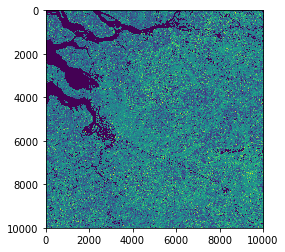

In [38]:
import boto3
import rasterio
from rasterio.session import AWSSession
from rasterio.windows import Window
from matplotlib import pyplot

session = boto3.Session(aws_access_key_id=s3_access_key, aws_secret_access_key=s3_access_secret)

# show the lenght of season 1 for LAEA tile E39N31
with rasterio.Env(AWSSession(session), AWS_S3_ENDPOINT='data.cloudferro.com', AWS_HTTPS='NO', AWS_VIRTUAL_HOSTING='FALSE') as env:
    with rasterio.open('/vsis3/{}/{}'.format('HRVPP', 'CLMS/Pan-European/Biophysical/VPP_LAEA/v01/2020/s1/VPP_2020_S2_E39N31-03035-010m_V101_s1_LENGTH.tif'), 'r') as ds:
        array = ds.read(1)
        pyplot.imshow(array)
        pyplot.show()